In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
from tqdm import tqdm
from scipy.linalg import eigvals
from scipy.stats import laplace
from scipy.stats import multivariate_normal
from scipy.special import expit
from sklearn.datasets import make_blobs
from sklearn.datasets import make_regression
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

# Bayesian Linear Regression with a Laplace prior distribution

In this notebook, we apply Stochastic Gradient Langevin Dynamics to perform Bayesian Linear Regression with a Laplace prior of scale $b=1$. For now, we fix the variance of the Gaussian likelihood to $\sigma^2=1$. We also compare Stochastic Gradient Langevin Dynamics to other sampling methods to test its efficiency, particularly its speed.

The model is as follows:

- $p(\beta) \sim \mathcal{L}(0, 1)$, i.e. $p(\beta) \propto \exp(-\|\beta\|_1)$,
- For all $i \in \{1, \dots, N\}$, $y_i \sim \mathcal{N}(x_i^{\top}\beta, \sigma^2)$, i.i.d.

Thus, the log posterior is:
$$
\log p(\beta | X, y) \propto - \sum_{i=1}^N (x_i^{\top}\beta - y_i)^2 - \|\beta \|_1 = - \|X\, \beta - y\|_2^2 - \|\beta \|_1
$$

Using the fact that a subgradient of the log-prior is $\partial_{\beta} \log p(\beta) = - \mathrm{sign}(\beta)$ and letting $X$ represent the data matrix, i.e.
$$
X = \begin{pmatrix}
x_1 \\
\vdots \\
x_n
\end{pmatrix} \in \mathbb{R}^{n \times d}
$$
and $y$ the vector of labels, we can write a subgradient of the log-posterior as:
$$
\partial_{\beta} \log p(\beta | X, y) = - X^{\top}X \, \beta + X^{\top}y - \mathrm{sign}(\beta)
$$


## 1. Stochastic Gradient Langevin Dynamics
We briefly outline an iteration of the algorithm here, in the specific case of Bayesian Linear Regression with a Laplace prior of scale $b=1$.


### 1.1 Algorithm

Using the previous calculations, the $t$-th iteration of **SGLD** is written as follows:

- Select a batch $B_t = \{x_{i_1}, ..., x_{i_n}\}$, form the corresponding data matrix $X_B = \begin{pmatrix}
x_{i_1}\\
\vdots\\
x_{i_n}
\end{pmatrix} \in \mathbb{R}^{|B| \times d}$, and $y_B$ the corresponding label vector.

- Compute the step-size $\epsilon_t = a \cdot (b+t)^{-\gamma}$.

- Sample $\eta_t \sim \mathcal{N}(0, \epsilon_t \cdot I)$.

- Update $\beta_{t+1} \leftarrow \beta_t + \frac{1}{2} \epsilon_t \cdot \left[ \frac{N}{n} \left( - X_B^{\top}X_B \, \beta + X_B^{\top}y_B \right) - \mathrm{sign}(\beta)\right] + \eta_t$.


### 1.2 Implementation

In [ ]:
def get_step_size(a, b, gamma, t):
    """
    Get the step size for parameters (a, b, gamma) at iteration t.
    Arguments:
      a: float, plays a role of learning rate
      b: float, controls the learning rate decay for the first iterations
      gamma: float in (.5, 1], controls step size decay
      t: int, iteration number
    Return:
      float, step_size
    """
    return a * (b + t) ** (- gamma)

def post_laplace(beta, X, y, sigma2=1):
    """
    Evaluate the (unormalized) posterior over the whole training set in beta.
    For numerical stability, prefer np.exp(log_post_laplace(beta, X, y)) to compute posterior pdf.
    Arguments:
      beta: np.array, parameter of logistic regression
      X: np.array,  training examples
      y: np.array, training labels
      sigma2: float, noise of the Gaussian likelihood
    Return:
      float, (unormalized) posterior evaluated in beta
    """
    mean = X @ beta
    cov = sigma2 * np.eye(len(X))
    return multivariate_normal(mean=mean, cov=cov).pdf(y) * np.exp(- np.linalg.norm(beta, ord=1))

def log_post_laplace(beta, X, y, sigma2=1):
    """
    Evaluate the (unormalized) log-posterior pdf over the whole training set in beta.
    Arguments:
      beta: np.array, parameter of logistic regression
      X: np.array,  training examples
      y: np.array, training labels
      sigma2: float, noise of the Gaussian likelihood
    Return:
      float, (unormalized) log-posterior evaluated in beta
    """
    return - (1/2) * np.linalg.norm(X @ beta - y, ord=2)**2 - np.linalg.norm(beta, ord=1)

def gradient_laplace(beta, batch_X, batch_y, n_samples, bool_cov_score=False, sigma2=1):
    """
    Get a sub-gradient of the log-posterior pdf w.r.t beta for a given batch.
    Arguments:
      beta: np.array, parameter of logistic regression
      batch_X: np.array, batch of training examples
      y: np.array, labels of training examples in the batch
      n_samples, int, number of samples in the training set
      bool_cov_score: boolean, if True compute the covariance of the score (to estimate the beginning of the sampling phase)
      sigma2: float, noise of the Gaussian likelihood
    Return:
      batch_grad: np.array, sub-gradient of the log-posterior w.r.t beta for the given batch
      cov_score: np.array, empirical covariance of the score (score = partial gradient for each sample in the batch + 1/n_samples sub-gradient of the prior)
    """
    # get batch gradient
    batch_grad = (n_samples / len(batch_X)) * (- batch_X.T @ batch_X @ beta + batch_X.T @ batch_y) - np.sign(beta)
    if bool_cov_score==False:
        return batch_grad

    # get empirical covariance of the score if required
    else:
        # get score
        res = -  ((batch_X @ beta) - batch_y)[:, None] * batch_X
        res2 = res - (1/n_samples) * np.sign(beta)

        # get empirical covariance
        cov_score = (1 / len(batch_X)) * (res2 - res2.mean(0)).T @ (res2 - res2.mean(0))
        return batch_grad, cov_score

def SGLD_linreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, sigma2=1, bool_trackW=False, bool_trackL=False, bool_trackA=False, verbose=True):
    """
    SGLD for Bayesian Linear Regression with Laplace Prior.
    Arguments:
      X: np.array,  training examples
      y: np.array, training labels
      n_iter: int, number of iterations
      a: float, plays a role of learning rate
      b: float, controls the learning rate decay for the first iterations
      gamma: float in (.5, 1], controls step size decay
      beta_0: np.array, initial beta
      batch_size: int, size of the batch
      sigma2: float, noise of the Gaussian likelihood
      bool_trackL: boolean, if True compute and return the log-posterior at each step (costly: require a pass over the whole training set)
      bool_weights: boolean, if True return the weights at each iteration to compute posterior expectation (as proposed in the article)
      bool_trackA: boolean, if True compute and return the alpha to evaluate begining of the sampling phase (see article for expression)
      verbose: boolean, if True print info about the run. If false, just return the time taken to compute
    Return:
      tackL: np.array, log-posterior evaluate at each step
      betas: np.array, paremeters at each step
    """
    start = time.time()
    N, dim = X.shape
    beta = beta_0
    betas = np.concatenate((beta[None, :], np.zeros((n_iter, dim))), axis=0)

    # compute and store log-posterior throughout the iterations if required
    if bool_trackL:
        trackL = np.concatenate(([log_post_laplace(beta, X, y)], np.zeros(n_iter)))

    # store weights throughout the iterations if required
    if bool_trackW:
        trackW = np.zeros(n_iter)

    # store weights throughout the iterations if required
    if bool_trackA:
        trackA = np.zeros(n_iter)

    iterator = tqdm(range(n_iter)) if verbose else range(n_iter)
    for ii in iterator:

        # select a batch of size batch_size
        idxs = np.random.choice(N, size=batch_size)
        batch_X = X[idxs]
        batch_y = y[idxs]

        ### STEP 1: ###
        # compute step size
        step_size = get_step_size(a, b, gamma, t=ii)

        ### STEP 2: ###
        # sample noise
        eta = multivariate_normal.rvs(mean=np.zeros(dim), cov=step_size*np.eye(dim))

        ### STEP 3: ###
        # update and store parameter
        if bool_trackA:
            grad, cov_score = gradient_laplace(beta, batch_X, batch_y, n_samples=N, bool_cov_score=True)
        else:
            grad = gradient_laplace(beta, batch_X, batch_y, n_samples=N)
        beta = beta + (step_size / 2) * grad + eta
        betas[ii+1] = beta

        # compute and store log-posterior if required
        if bool_trackL:
            trackL[ii+1] = log_post_laplace(beta, X, y)

        # store weights if required
        if bool_trackW:
            trackW[ii] = step_size

        # compute and store alpha if required
        if bool_trackA:
            trackA[ii] = ((step_size * N**2) / (4 * len(batch_X))) * np.amax(np.real(eigvals(cov_score)))

    end = time.time()
    time.sleep(.1)
    if verbose:
        print(f"Done in {round(end-start, 2)} s.")
    else:
        return end-start

    if bool_trackA & bool_trackW & bool_trackL:
        return betas,trackA, trackW, trackL
    if bool_trackA & bool_trackW:
        return betas, trackA, trackW
    if bool_trackA & bool_trackL:
        return betas, trackA, trackL
    if bool_trackW & bool_trackW:
        return betas, trackW, trackL
    if bool_trackA:
        return betas, trackA
    if bool_trackW:
        return betas, trackW
    if bool_trackL:
        return betas, trackL
    else:
        return betas

def predictive_MC(X_new, samples, burn_in=None, weights=None):
    """
    Get an approimation of the mean of predictive distribution by Monte-Carlo approximation.
    Arguments:
      X_new: np.array, new unseen examples
      samples: np.array,  samples from the posterior (size = n_samples x dim)
      burn_in: int, threshold to get actual sample from the posterior (time for the markov reach to reach its stationnary distribution)
      weights: np.array, weights to compute expectation (if None: uniform weights)
    Return:
      np.array, predictive distribution
    """
    if burn_in==None:
        burn_in=1
    if np.all(weights)==None:
        return (X_new @ samples[burn_in+1:].T).mean(1)
    else:
        return (weights[None, burn_in:] * X_new @ samples[burn_in+1:].T).sum(1) / weights[burn_in:].sum()

def get_mse_iter(X, y, samples, burn_in=None):
    """
    Get the mean squared error (training or testing) given by the sample at each iteration.
    Arguments:
      X: np.array, training or testing examples
      y: np.array,  training or testing labels
      samples: np.array,  samples from the posterior (size = n_samples x dim)
      burn_in: int, threshold to get actual sample from the posterior (time for the markov reach to reach its stationnary distribution)
    Return:
      np.array, accuracy (training or testing) at each iteration
    """
    if burn_in==None:
        burn_in=1
    return (X @ samples[burn_in:].T - y[:, None]).var(0)

### 1.3 Application on the synthetic regression dataset

In this section, we test our implementation of SGLD on a dataset in $\mathbb{R}$. Thus, we can test the validity of our method.


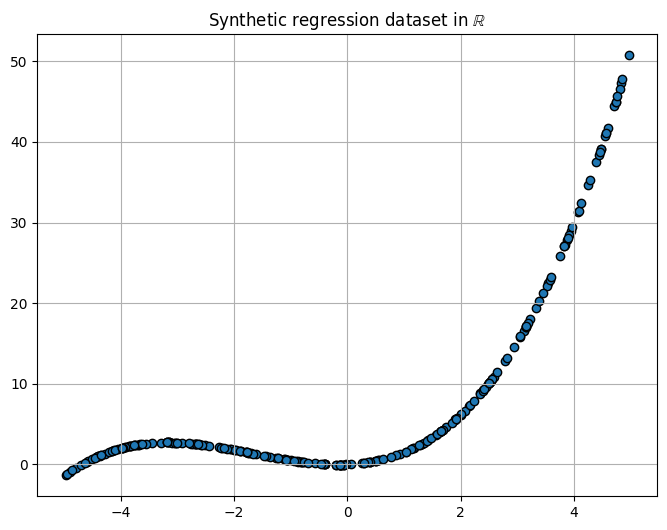

In [ ]:
# load linearly separable dataset
x = np.linspace(-5, 5, 1000)[np.random.choice(1000, size=250)]
y = .2 * x**3 + x**2 + .3 * x

# visualize dataset
plt.figure(figsize=(8,6))
plt.scatter(x, y, edgecolors='k')
plt.title("Synthetic regression dataset in $\mathbb{R}$")
plt.grid()
plt.show()

In [ ]:
# polynomial transformation of the features
poly = PolynomialFeatures(3, include_bias=False)
phi_X = poly.fit_transform(x[:, None])

# standardize data
scaler = StandardScaler().fit(phi_X)
phi_X = scaler.transform(phi_X)

# add bias
phi_X = np.concatenate((np.ones(len(phi_X))[:, None], phi_X), axis=1)

print(f"Number of points: {phi_X.shape[0]}.")
print(f"Number of dimension of the new covariates: {phi_X.shape[1]}.")

Number of points: 250.
Number of dimension of the new covariates: 4.


In [ ]:
a = .005
b = 50
gamma = .7
batch_size = 5
beta_0 = np.zeros(phi_X.shape[1])
n_iter = 5000

# without computing log-posterior at each step
print(f"Without computing any auxilliary quantity at each step (no log-posterior, no alpha):")
time.sleep(1)
betas = SGLD_linreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size)

# re-inject last sample in the next run
beta_0 = betas[-1]

# computing log-posterior at each step
print(f"\nComputing just the log-posterior at each step:")
time.sleep(1)
betas, trackL = SGLD_linreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True)

# re-inject last sample in the next run
beta_0 = betas[-1]

# computing alphas at each step
print(f"\nComputing just the alphas at each step:")
time.sleep(1)
betas, trackA = SGLD_linreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackA=True)

# re-inject last sample in the next run
beta_0 = betas[-1]

# computing both alphas and log-posterior at each step
print(f"\nComputing both the log-posterior and the alphas at each step:")
time.sleep(1)
betas, trackA, trackL = SGLD_linreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True, bool_trackA=True)

Without computing any auxilliary quantity at each step (no log-posterior, no alpha):


100%|██████████| 5000/5000 [00:01<00:00, 3079.50it/s]


Done in 1.63 s.

Computing just the log-posterior at each step:


100%|██████████| 5000/5000 [00:01<00:00, 2597.89it/s]


Done in 1.93 s.

Computing just the alphas at each step:


100%|██████████| 5000/5000 [00:02<00:00, 2183.00it/s]


Done in 2.29 s.

Computing both the log-posterior and the alphas at each step:


100%|██████████| 5000/5000 [00:03<00:00, 1493.49it/s]


Done in 3.35 s.


In [ ]:
a = .01
b = 50
gamma = .6
batch_size = 20
beta_0 = betas[-1] # re-inject last sample in the next run
n_iter = 5000

# computing both alphas and log-posterior at each step
print(f"Computing both the log-posterior, the alphas and storing the weights at each step:")
time.sleep(1)
betas, trackW, trackA, trackL = SGLD_linreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size,bool_trackA=True, bool_trackL=True, bool_trackW=True)

Computing both the log-posterior, the alphas and storing the weights at each step:


100%|██████████| 5000/5000 [00:02<00:00, 1701.80it/s]


Done in 2.94 s.


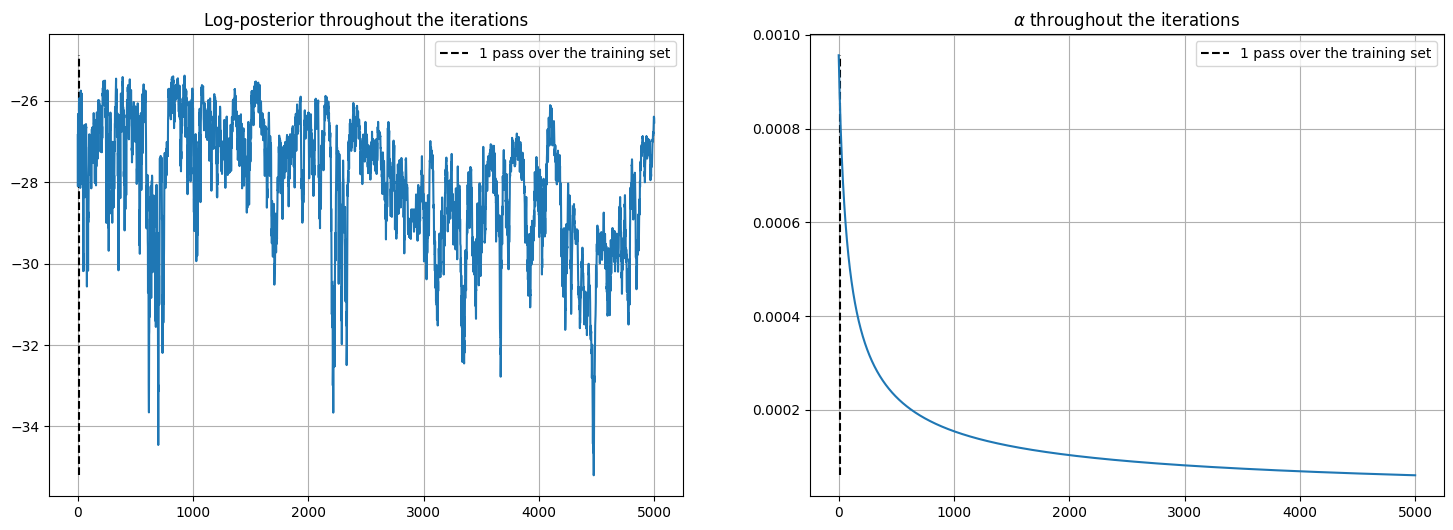

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = phi_X.shape[0]

# plot log-posterior
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=trackL.min(), ymax=trackL.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(trackL)
ax[0].set_title("Log-posterior throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot alphas
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=trackA.min(), ymax=trackA.max(), ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(trackA)
ax[1].set_title("$\\alpha$ throughout the iterations")
ax[1].legend()
ax[1].grid()


plt.show()

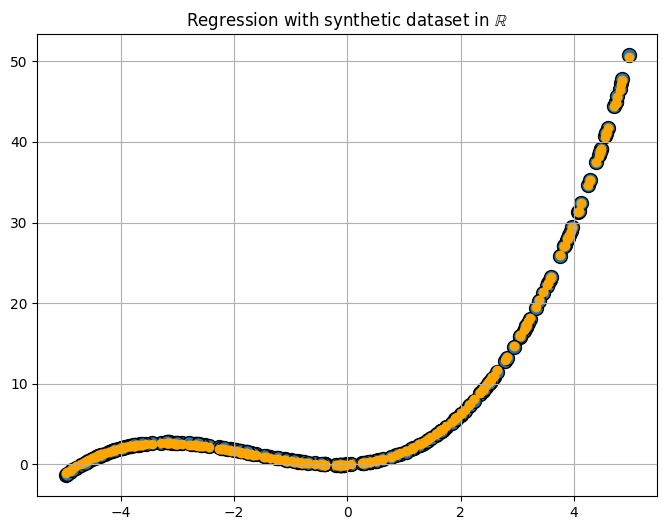

In [ ]:
# visualize reusults
plt.figure(figsize=(8,6))
plt.scatter(x, y, edgecolors='k', s=100)
plt.scatter(x, phi_X @ betas[-100:].mean(0), color='orange', lw=1)
plt.title("Regression with synthetic dataset in $\mathbb{R}$")
plt.grid()
plt.show()